In [1]:
import pandas as pd
import missingno as msno
import numpy as np

import copy
import unicodedata

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Movie Recommendation System (Modeling)

[Here](https://hatefdastour.github.io/portfolio/recommendation_system/Movie_Recommendation_system_Preprocessing.html), we have already cleaned the data available from Kaggle.com ([link to Data](https://www.kaggle.com/carolzhangdc/imdb-5000-movie-dataset)). In this article, a model using is developed that recommended a number of movies for a given movie title (from the available titles in the data).


#### Table of contents
* [Initial Analysis](#Initial-Analysis)
* [Modeling](#Modeling)
* [Movie Recommendations](#Movie-Recommendations)

#### Loading the preprocessed data

In [2]:
Data = pd.read_csv('Data/clean_movie_metadata.csv')

## Initial Analysis

The columns of the data:

In [3]:
Columns=list(Data.columns)
Columns

['actor_1_facebook_likes',
 'actor_1_name',
 'actor_2_facebook_likes',
 'actor_2_name',
 'actor_3_facebook_likes',
 'actor_3_name',
 'budget',
 'cast_total_facebook_likes',
 'color',
 'content_rating',
 'country',
 'director_facebook_likes',
 'director_name',
 'duration',
 'genres',
 'gross',
 'imdb_score',
 'language',
 'movie_facebook_likes',
 'movie_title',
 'num_critic_for_reviews',
 'num_user_for_reviews',
 'num_voted_users',
 'plot_keywords',
 'title_year']

In [4]:
Ratings=Data[['movie_title','gross','imdb_score','num_critic_for_reviews', 'num_user_for_reviews']]
Ratings.sort_values(by='gross', ascending=False).head(10).style.hide_index()

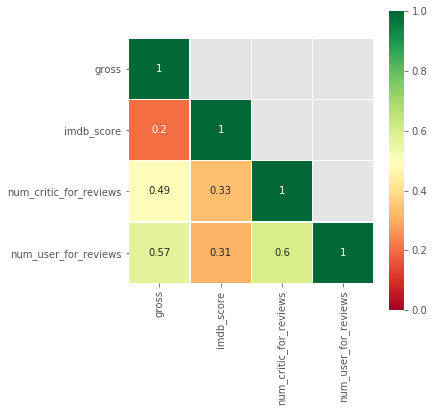

In [5]:
Rew_col_list=['gross','imdb_score','num_critic_for_reviews', 'num_user_for_reviews']
Correlation_Matrix = Ratings[Rew_col_list].corr()
mask = np.zeros_like(Correlation_Matrix)
mask[np.triu_indices_from(mask)] = True
for i in range(len(mask)):
    mask[i,i]=0
plt.subplots(figsize=(5.5,5.5))
sns.heatmap(Correlation_Matrix, mask=mask, annot=True, square=True, 
            cmap ="RdYlGn", linewidths = 0.2, vmin=0, vmax=1)
del mask

It can be seen that both **the number of critics for reviews** and **the number of users for reviews** are highly correlated with **gross**.

Univariate plots:

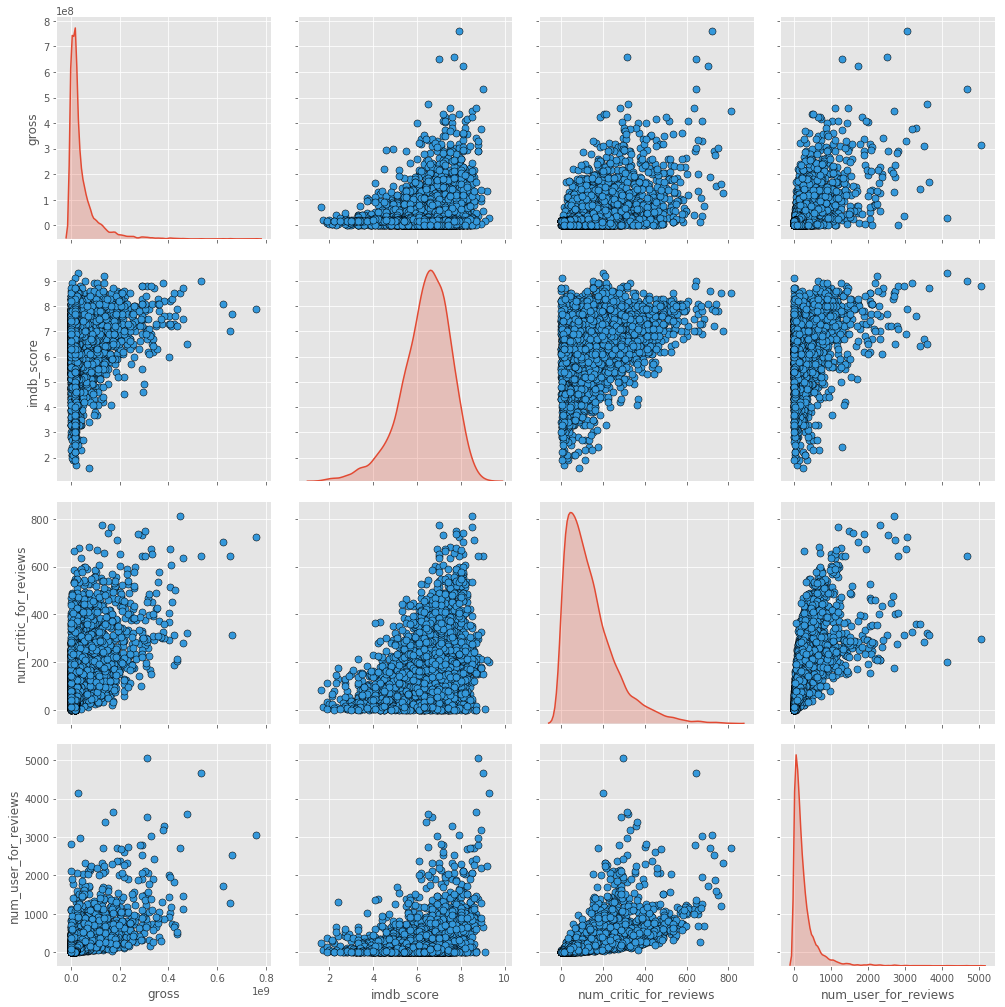

In [6]:
pp=sns.pairplot(Ratings, height=3.5,diag_kind="kde", 
             plot_kws=dict(s=50, color="#3498db", edgecolor="k", linewidth=0.5),
             diag_kws=dict(shade=True))

We can see that **the number of critics for reviews** and **the number of users for reviews** are highly correlated.

## Modeling

We would like to convert the data into only two columns. That is one column only the movie titles and the other one all relevant information about a movie. Since we don't have any information on users' performance. This is a way to model this data.

In [7]:
Drop_List=list()

for i in range(len(Columns)):
    if Columns[i].find('facebook') != -1:
        Drop_List.append(Columns[i])
    if Columns[i].find('num') != -1:
        Drop_List.append(Columns[i])
## Adding the rest of unrelated columns to the drop list       
Drop_List=Drop_List+['budget','duration','gross','imdb_score']

In [8]:
Data=Data.drop(columns=Drop_List)

This, the date reduces to

In [9]:
Data = Data.reindex(columns=sorted(Data.columns,reverse=True))
Data.head().style.hide_index()

Converting the Data to string.

In [10]:
Data=Data.astype(str)

More modifications on `genres` anc `plot_keywords` columns:

In [11]:
### genres
# converting to lower case
Data.genres = Data.genres.map(lambda x: x.lower())
# replacing '|' with ','
Data.genres = Data.genres.map(lambda x: x.split('|'))
# joining the string
Data.genres = Data.genres.str.join(' ') 

### plot_keywords
# converting to lower case
Data.plot_keywords = Data.plot_keywords.map(lambda x: x.lower())
# replacing '|' with ','
Data.plot_keywords = Data.plot_keywords.map(lambda x: x.split('|'))
Data.plot_keywords = Data.plot_keywords.str.join(' ') 

The resulting Data

In [12]:
Data.head().style.hide_index()

Mimicing the process for actors and directors names:

In [13]:
for i in range(len(Columns)):
    if Columns[i].find('name') != -1:
        Data[Columns[i]] = Data[Columns[i]].map(lambda x: x.split(' '))
        Data[Columns[i]] = Data[Columns[i]].str.join('')

In [14]:
Data.head().style.hide_index()

Converting the data to two columns only, `movie_title` and `other`

In [15]:
X = 'movie_title'
Y=list()
temp=Data.columns.tolist()
for i in range(len(temp)):
    if temp[i].find('movie_title') == -1:
         Y.append(temp[i])
del temp

In [16]:
Data['Other']=Data[Y[0]].astype(str)
for i in np.arange(1,len(Y)):
    Data['Other'] = Data['Other']+" "+ Data[Y[i]].astype(str)
del i

Droping Y columns

In [17]:
Data=Data.drop(columns=Y)
del X, Y

In [18]:
Data.head().style.hide_index()

Instantiating and generating the count matrix using [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

In [19]:
vectorizer = CountVectorizer()
Matrix= vectorizer.fit_transform(Data['Other'])
# to view the entries run the following command
# vectorizer.get_feature_names()

Next, we are going to use [cosine_similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) to find similarities.

In [20]:
Similarity_Matrix = cosine_similarity(Matrix, dense_output=True)
Similarity_Matrix

array([[1.        , 0.38138504, 0.31622777, ..., 0.1860521 , 0.29880715,
        0.17888544],
       [0.38138504, 1.        , 0.30151134, ..., 0.17739372, 0.28490144,
        0.17056057],
       [0.31622777, 0.30151134, 1.        , ..., 0.19611614, 0.25197632,
        0.14142136],
       ...,
       [0.1860521 , 0.17739372, 0.19611614, ..., 1.        , 0.37062466,
        0.16641006],
       [0.29880715, 0.28490144, 0.25197632, ..., 0.37062466, 1.        ,
        0.21380899],
       [0.17888544, 0.17056057, 0.14142136, ..., 0.16641006, 0.21380899,
        1.        ]])

## Movie Recommendations

In [33]:
def recommend_movies(title, Number_Of_Recommendations, Sim_Matrix=Similarity_Matrix):
    # Recommended Movies List 
    Recommended_Movies_List  = []
    
    # the index of 'title' from the dataframe
    title_index = Data[Data['movie_title'].str.match(title)].index[0]
    
    # 'title' matches in descending order
    Title_Matches = pd.Series(Sim_Matrix[title_index]).sort_values(ascending = False)

    # Picking Number_Of_Recommendations movies
    Recom_index = list(Title_Matches.iloc[1:Number_Of_Recommendations].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in Recom_index:
        Recommended_Movies_List.append(list(Data.movie_title)[i].replace(u'\xa0', u''))
    
    Recommended_Movies_List=pd.DataFrame(Recommended_Movies_List,
                                         columns=['Recommended Titles']).style.hide_index()    
    return Recommended_Movies_List

For example, consider **The Dark Knight**. For this movie, the following ten movies are recommended.

In [35]:
recommend_movies('The Dark Knight', 10)